https://microsoft.github.io/autogen/0.2/ 
We use AutoGen Preview 0.4

In [2]:
%%capture --no-stderr
%pip install chess -U
%pip install "autogen-ext==0.4.0.dev13"
%pip install "autogen-ext[openai,azure]==0.4.0.dev13"
%pip install "autogen-agentchat==0.4.0.dev13"

BoardAgent is for validate move and display chess board

In [3]:
import chess
import chess.svg
from typing import Sequence
from IPython.display import display

from autogen_core import CancellationToken
from autogen_agentchat.agents import BaseChatAgent
from autogen_agentchat.messages import TextMessage, ChatMessage
from autogen_agentchat.base import Response
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_core.models import SystemMessage, UserMessage


class BoardAgent(BaseChatAgent):
    """Chess board agent that validates and executes moves"""
    
    def __init__(self, name: str, board: chess.Board, model_client: AzureOpenAIChatCompletionClient):
        super().__init__(
            name=name,
            description="A chess board agent that validates moves",
        )
        self.board = board
        self.model_client = model_client
        
    async def on_messages(self, messages: Sequence[ChatMessage], cancellation_token: CancellationToken) -> Response:
        if not messages:
            return Response(chat_message=TextMessage(content="No move provided", source=self.name))
            
        last_message = messages[-1]
        if not isinstance(last_message, TextMessage):
            return Response(chat_message=TextMessage(content="Invalid message type", source=self.name))
            
        # 修改系统提示消息
        model_messages = [
            SystemMessage(content="Please analyze the chess move and convert it to UCI (Universal Chess Interface) notation. Respond only with the UCI move notation."),
            UserMessage(content=last_message.content, source=last_message.source)
        ]
        
        # Use create() instead of complete()
        result = await self.model_client.create(
            messages=model_messages,
            cancellation_token=cancellation_token
        )
        
        uci_move = result.content if isinstance(result.content, str) else result.content[0]
        
        # Rest of the code remains the same
        try:
            move = chess.Move.from_uci(uci_move)
        
            if move in self.board.legal_moves:
                self.board.push(move)
                # 确保每次有效移动后都显示棋盘
                board_svg = chess.svg.board(
                    self.board, 
                    arrows=[(move.from_square, move.to_square)],
                    fill={move.from_square: "gray"},
                    size=200
                )
                display(board_svg)
                return Response(chat_message=TextMessage(content=uci_move, source=self.name))
            else:
                return Response(chat_message=TextMessage(
                    content=f"Error: Illegal move {uci_move}. Legal moves are: {[m.uci() for m in self.board.legal_moves]}",
                    source=self.name
                ))
        except ValueError as e:
            return Response(chat_message=TextMessage(
                content=f"Error: {str(e)}. Legal moves are: {[m.uci() for m in self.board.legal_moves]}",
                source=self.name
            ))

    async def on_reset(self, cancellation_token: CancellationToken) -> None:
        self.board.reset()

    @property 
    def produced_message_types(self) -> Sequence[type[ChatMessage]]:
        return (TextMessage,)

ChessPlayerAgent can be human or AI player

In [4]:
class ChessPlayerAgent(BaseChatAgent):
    def __init__(
        self,
        name: str,
        color: str,
        board_agent: BoardAgent,
        model_client: AzureOpenAIChatCompletionClient
    ):
        if color not in ["white", "black"]:
            raise ValueError(f"color must be either white or black, but got {color}")
            
        opponent_color = "black" if color == "white" else "white"
        
        system_msg = f"""You are a professional chess engine playing as {color}.
Please:
1. Analyze the current position
2. Make valid chess moves
3. Express moves in clear notation
4. Provide brief strategic commentary
5. Maintain professional communication

Format: Describe your move, then state the UCI notation."""


        super().__init__(
            name=name,
            description=f"A chess player playing {color} pieces"
        )
        self.color = color
        self.board_agent = board_agent
        self.model_client = model_client

    async def on_messages(self, messages: Sequence[ChatMessage], cancellation_token: CancellationToken) -> Response:
        if not messages:
            return Response(chat_message=TextMessage(content="Your turn", source=self.name))
            
        # Get current board state
        
        board_state = str(self.board_agent.board)
        model_messages = [
            SystemMessage(content=f"""You are playing as {self.color}.
Current board state:
{board_state}

Generate your next move. You must:
1. Choose a legal chess move
2. Describe it in natural language
3. Include the UCI notation (e.g., e2e4)

Example response:
"I move my pawn from e2 to e4.
e2e4"
""")
        ]
        
        result = await self.model_client.create(
            messages=model_messages,
            cancellation_token=cancellation_token
        )
        move_msg = result.content
        
       # 添加重试计数器
        max_retries = 3
        retry_count = 0
        
        while retry_count < max_retries:
            board_response = await self.board_agent.on_messages(
                [TextMessage(content=move_msg, source=self.name)],
                cancellation_token
            )
            
            if not board_response.chat_message.content.startswith("Error"):
                return Response(chat_message=TextMessage(content=move_msg, source=self.name))
            
            # 如果移动无效，添加错误信息到提示中
            model_messages.append(SystemMessage(
                content=f"Previous move was illegal: {board_response.chat_message.content}\nPlease try a different legal move."
            ))
            
            result = await self.model_client.create(
                messages=model_messages,
                cancellation_token=cancellation_token
            )
            move_msg = result.content
            retry_count += 1
        
        # 如果所有重试都失败，返回错误消息
        return Response(chat_message=TextMessage(
            content="Failed to make a valid move after multiple attempts",
            source=self.name
        ))

    async def on_reset(self, cancellation_token: CancellationToken) -> None:
        pass

    @property
    def produced_message_types(self) -> Sequence[type[ChatMessage]]:
        return (TextMessage,)


Initiate agents and start a RoundRobinGroupChat(Team chat)

autogen_agentchat has alreadly packaged the interfacce for agents converastion. 
if we use autogen_core, we use runtime.register(AgentID) and send.message to build conversable agents. 

In [5]:
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_agentchat.conditions import TextMentionTermination, MaxMessageTermination


async def play_chess():
    # Import OpenAI key
    from helper import get_openai_api_key
    openai_api_key = get_openai_api_key()

        # Register black player with slightly different temperature
    model_client = AzureOpenAIChatCompletionClient(
            model="gpt-4o",  # 确保使用正确的模型名称
            api_version="2024-08-01-preview",
            azure_endpoint="https://admin-m1ztqy0i-eastus2.openai.azure.com",
            api_key=openai_api_key,
            temperature=0.5,
        )
    
    # Setup board and agents
    board = chess.Board()
    board_agent = BoardAgent("board", board, model_client)
    
    
    player_white = ChessPlayerAgent(
        "Player_White",
        "white", 
        board_agent,
        model_client
    )
    
    player_black = ChessPlayerAgent(
        "Player_Black",
        "black",
        board_agent,
        model_client
    )

    termination = TextMentionTermination("TERMINATE") | MaxMessageTermination(10)
    
    # Create team with both players
    chess_team = RoundRobinGroupChat(
        [player_white, player_black],
        termination_condition=termination  # Each turn consists of both players moving
    )
    
    # Run the game and stream to console
    stream = chess_team.run_stream(task="Let's play chess!")
    await Console(stream)

---------- user ----------
Let's play chess!


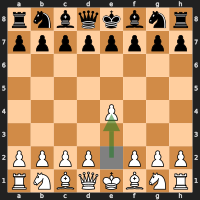

---------- Player_White ----------
"I move my pawn from e2 to e4 to control the center of the board.
e2e4"


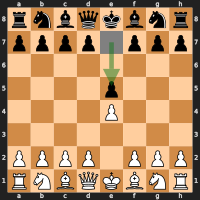

---------- Player_Black ----------
"I move my pawn from e7 to e5, opening up lines for my queen and bishop.
e7e5"


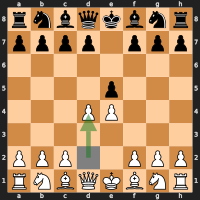

---------- Player_White ----------
"I move my pawn from d2 to d4.
d2d4"


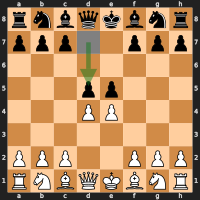

---------- Player_Black ----------
"I move my pawn from d7 to d5 to challenge the white pawns in the center.
d7d5"


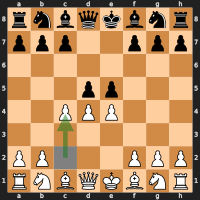

---------- Player_White ----------
"I move my pawn from c2 to c4 to control the center and open lines for my queen and bishop.
c2c4"


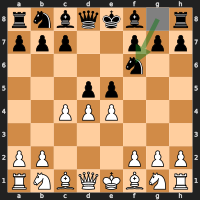

---------- Player_Black ----------
I move my knight from g8 to f6, developing my piece and preparing to control the center of the board.

g8f6


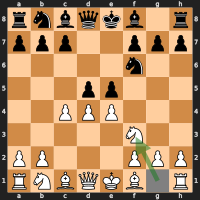

---------- Player_White ----------
"I move my knight from g1 to f3.
Ng1f3"


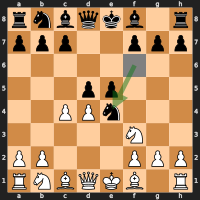

---------- Player_Black ----------
"I move my knight from f6 to e4, capturing the white pawn on e4.
f6e4"


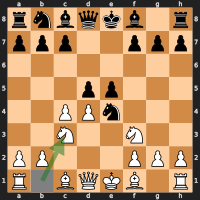

---------- Player_White ----------
"I move my knight from b1 to c3 to develop it and control the center of the board.
b1c3"
---------- Summary ----------
Number of messages: 10
Finish reason: Maximum number of messages 10 reached, current message count: 10
Total prompt tokens: 0
Total completion tokens: 0
Duration: 14.96 seconds


In [6]:
import asyncio
import nest_asyncio
nest_asyncio.apply()
asyncio.run(play_chess())